In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import ast
from rich.console import Console
from rich import print
from rich.style import Style

sns.set()
pd.set_option('display.max_columns', None)

In [46]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

## DataPreprocessing

In [55]:
df = movies.merge(credits, on='title')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [56]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
movie_id                  int64
cast                     object
crew                     object
dtype: object

In [57]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [58]:
df['genres'] = df['genres'].apply(ast.literal_eval)
df['keywords'] = df['keywords'].apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(ast.literal_eval)
df['spoken_languages'] = df['spoken_languages'].apply(ast.literal_eval)
df['cast'] = df['cast'].apply(ast.literal_eval)

# Extracting information in a different format
df['genres'] = df['genres'].apply(lambda x: [genre['name'] for genre in x])
df['keywords'] = df['keywords'].apply(lambda x: [keyword['name'] for keyword in x])
df['production_companies'] = df['production_companies'].apply(lambda x: [company['name'] for company in x])
df['production_countries'] = df['production_countries'].apply(lambda x: [country['name'] for country in x])
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [language['name'] for language in x])
df['cast'] = df['cast'].apply(lambda x: [language['name'] for language in x])

In [59]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [60]:
df_null = df.isnull().sum()
df_null[df_null>0]

homepage        3096
overview           3
release_date       1
runtime            2
tagline          844
dtype: int64

In [61]:
df['homepage'] = df['homepage'].fillna('Not Available')
df['tagline'] = df['tagline'].fillna('Not Available')

df = df.dropna()

In [62]:
def clean_and_join(string):
    new = " ".join(string) 
    new = ''.join(e for e in new if e.isalnum() or e.isspace())  # Remove non alphanumeric character
    return new

In [64]:
columns_to_clean = ['genres','keywords','production_companies',
                    'production_countries','cast','spoken_languages']

df[columns_to_clean] = df[columns_to_clean].map(clean_and_join)

In [66]:
df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners Twentieth Century Fox ...,United States of America United Kingdom,2009-12-10,2787965087,162.0,English Español,Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures Jerry Bruckheimer Films S...,United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6 bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,Columbia Pictures Danjaq B24,United Kingdom United States of America,2015-10-26,880674609,148.0,Français English Español Italiano Deutsch,Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,"[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [68]:
df.crew.value_counts()

crew
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [85]:
# These columns will generate the vector store
df['genre_keywords_similarity'] = df['genres'].str.cat([df['keywords']], sep=' ')

df['production_casting_similarity'] = df['production_companies'].str.cat(
    [df['cast'],df['production_countries']], sep=' ')

In [69]:
df.to_csv('wow.csv')

## EDA

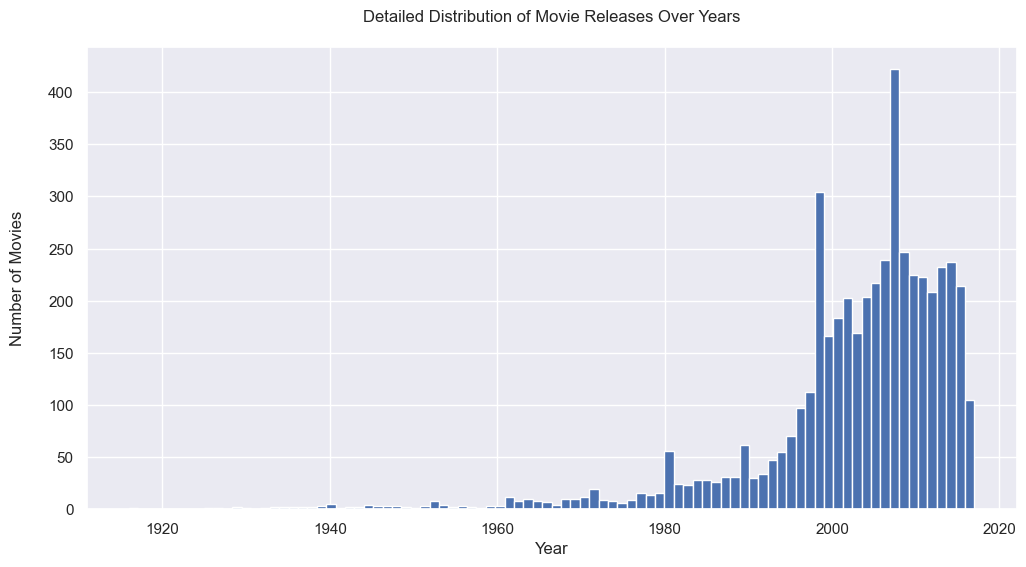

In [78]:
plt.figure(figsize=(12,6))
ax = df['release_date'].dt.year.hist(bins=len(df['release_date'].dt.year.unique()))
ax.set_ylabel("Number of Movies\n")
ax.set_xlabel("Year")
ax.set_title("Detailed Distribution of Movie Releases Over Years\n")
plt.show()

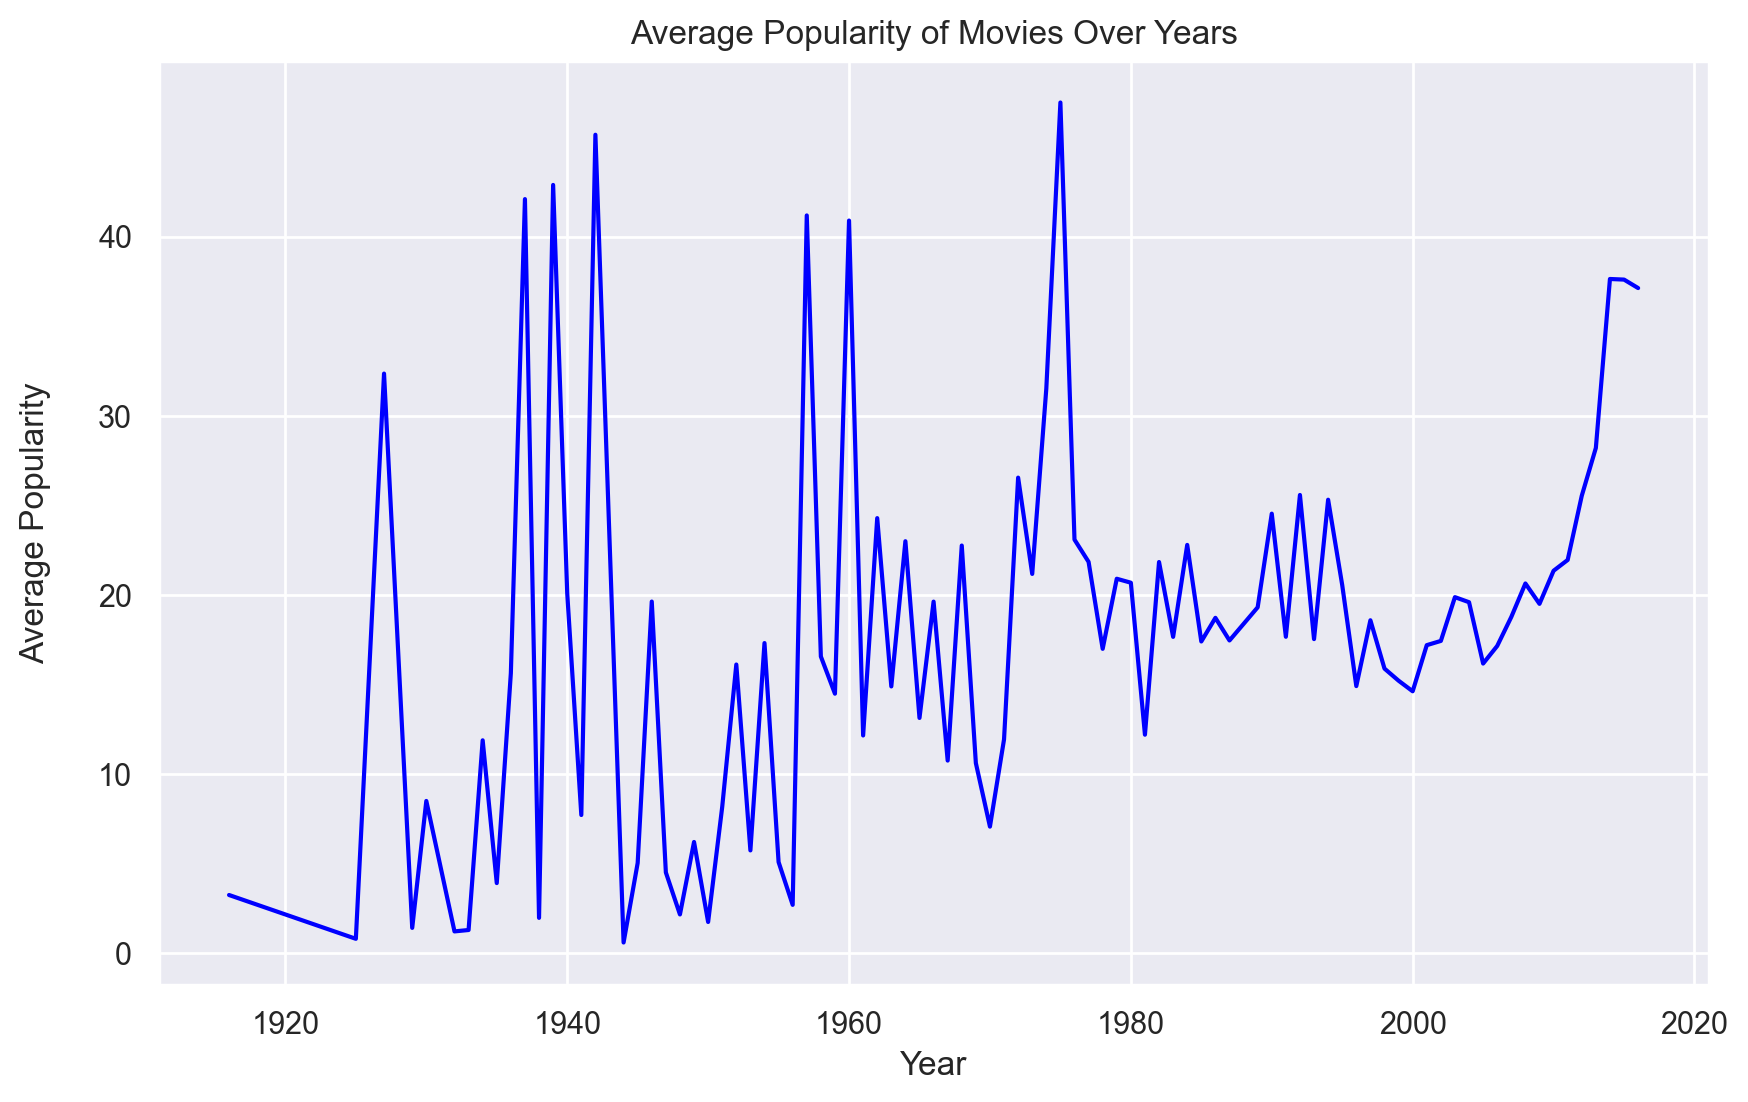

In [81]:
average_popularity_per_year = df.groupby(df['release_date'].dt.year)['popularity'].mean()
average_popularity_per_year = average_popularity_per_year[:-1] # Last point is outlier

# Creating the line plot again without the last point
plt.figure(figsize=(10,6), dpi=200)
average_popularity_per_year.plot(kind='line', color='blue')
plt.title("Average Popularity of Movies Over Years")
plt.ylabel("Average Popularity\n")
plt.xlabel("Year")
plt.show()

In [82]:
movie_index = pd.Series(df.index, index=df['title'])
movie_index.head(10)
# idx = movie_index['Avatar'] # Example usage


title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
Spider-Man 3                                5
Tangled                                     6
Avengers: Age of Ultron                     7
Harry Potter and the Half-Blood Prince      8
Batman v Superman: Dawn of Justice          9
dtype: int64

In [86]:
# create a tf-idf vectorizer object
tfidf = TfidfVectorizer(max_features=2000)

X_gen = tfidf.fit_transform(df['genre_keywords_similarity'])
X_prod = tfidf.fit_transform(df['production_casting_similarity'])

In [88]:
idx = movie_index['Avatar']
query = X_gen[idx]
query_prod = X_prod[idx]
query

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [92]:
scores_gen = cosine_similarity(query, X_gen)
scores_prod = cosine_similarity(query_prod, X_prod)
scores_gen

array([[1.        , 0.03861274, 0.01940785, ..., 0.02926901, 0.        ,
        0.        ]])

In [38]:
# currently the array is 1 x N
# i will make it a 1-D array
scores_gen = scores_gen.flatten()
scores_prod = scores_prod.flatten()

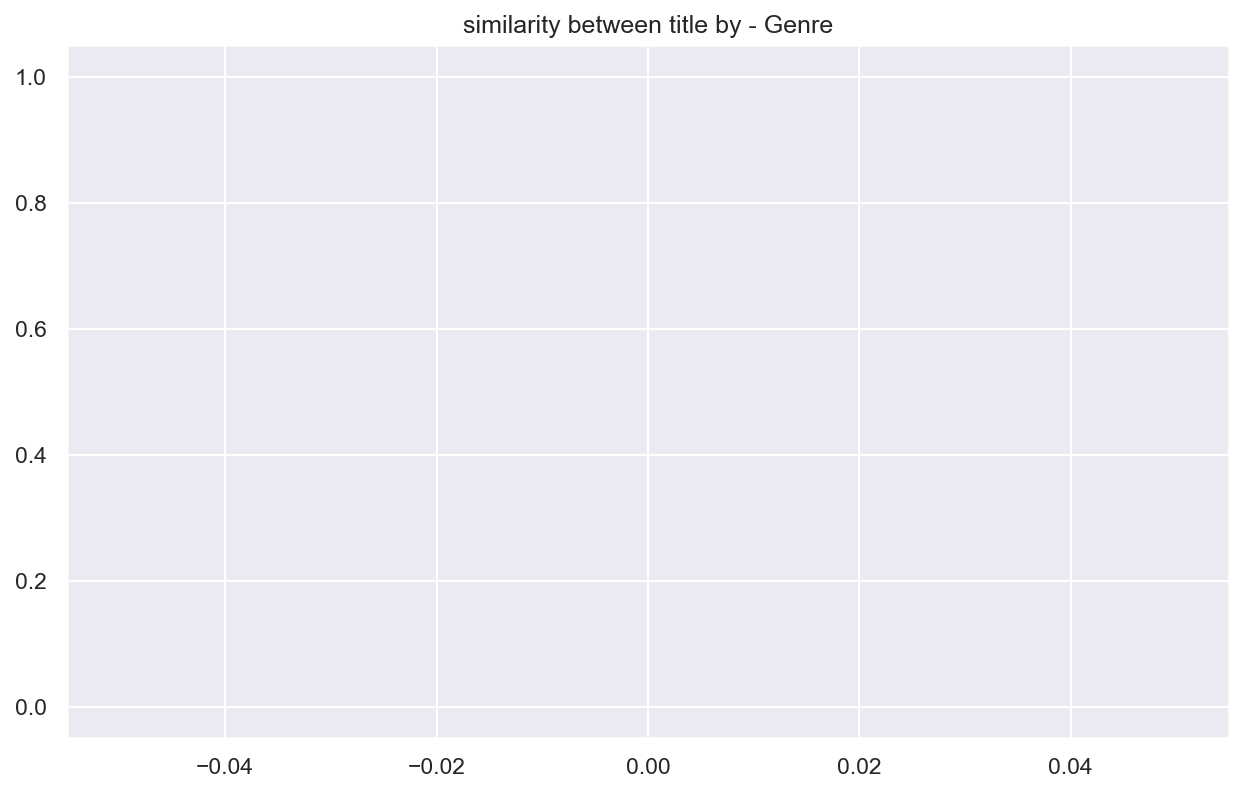

In [93]:
# illustrative purpose
plt.figure(figsize=(10,6),dpi=150)
plt.plot(scores_gen)
plt.title("similarity between title by - Genre")

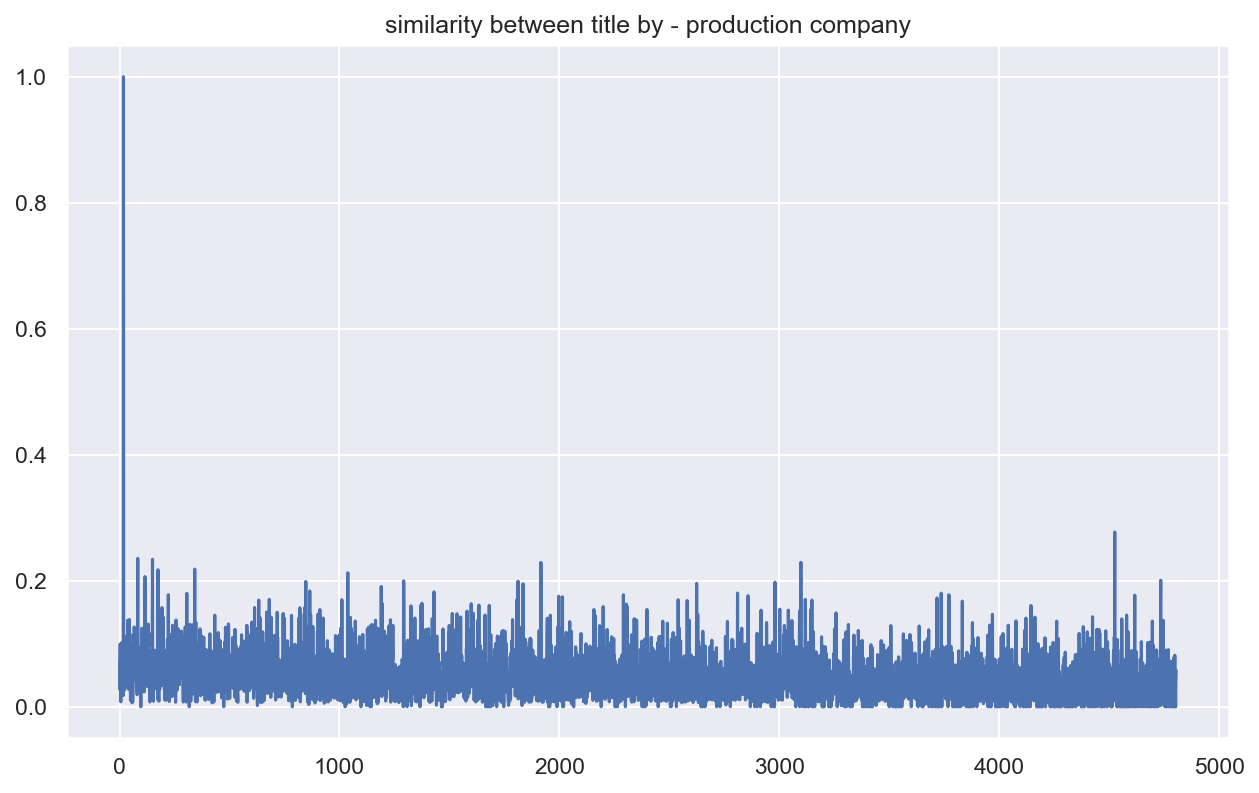

In [40]:
# illustrative purpose
plt.figure(figsize=(10,6),dpi=150)
plt.plot(scores_prod)
plt.title("similarity between title by - production company");

In [41]:
(-scores_gen).argsort()

array([  18,  466, 4451, ..., 1607, 3382, 4805], dtype=int64)

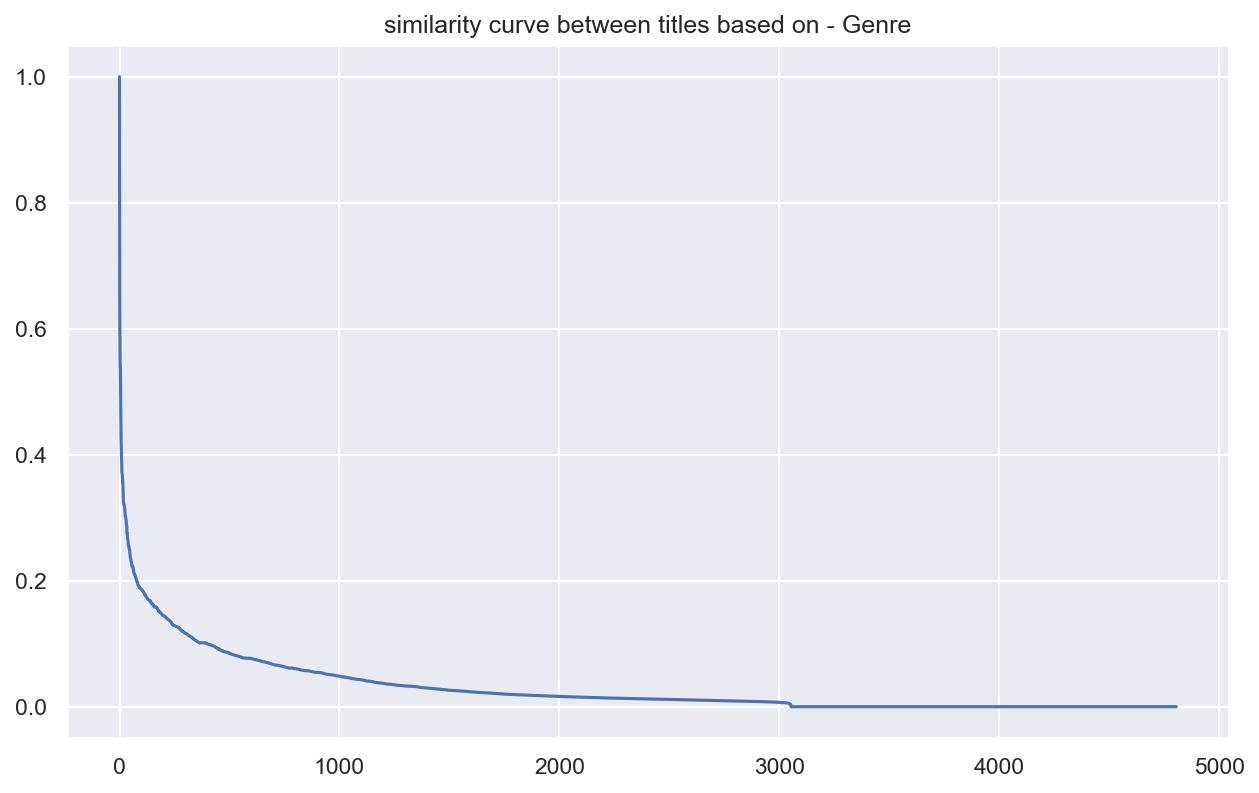

In [42]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(scores_gen[(-scores_gen).argsort()])
plt.title("similarity curve between titles based on - Genre");

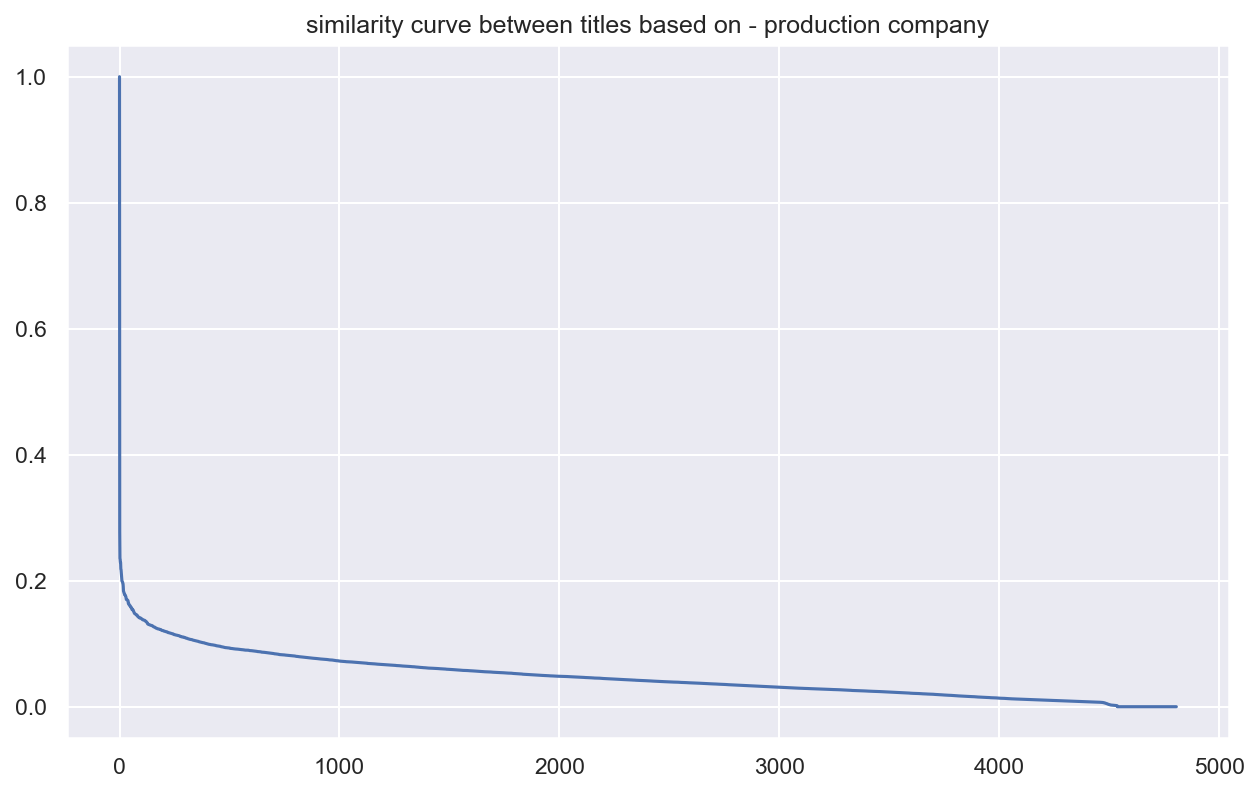

In [43]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(scores_prod[(-scores_prod).argsort()])
plt.title("similarity curve between titles based on - production company");

In [44]:
# get top 5 matches
# exclude self (similarity between query and itself yields max score)
recommended_gen_idx = (-scores_gen).argsort()[1:6]
recommended_prod_idx = (-scores_prod).argsort()[1:6]

In [45]:
# convert indices back to titles - genre
df['title'].iloc[recommended_gen_idx]

466          The Time Machine
4454             Time Changer
4476    Safety Not Guaranteed
2871          Project Almanac
3557        Somewhere in Time
Name: title, dtype: object

In [46]:
# convert indices back to titles - Company
df['title'].iloc[recommended_prod_idx]

4528        The Singles Ward
83                The Lovers
150          Men in Black II
3099    The Brothers Solomon
1916                 Hot Rod
Name: title, dtype: object

## Final Version
**Function - Raccomanded Films**

In [47]:
def raccomandation(title):
    
    # Style
    title_style = Style(color="bright_blue", bold=True)
    h2_style = Style(color="orange1")
    highlight_style = Style(color="black")
    
    # Avoid the wrong titles
    if title not in movie_Index:
        print("Enter a Valid Title")
    else:
        # title index
        idx = movie_Index[title]
        # Query - genre
        query = X_gen[idx]
        query = query.toarray()
        # Query - production company
        query_prod = X_prod[idx]
        query_prod = query_prod.toarray()
        
        #scores - genre
        scores_gen = cosine_similarity(query, X_gen)
        scores_gen = scores_gen.flatten()
        #scores - production company
        scores_prod = cosine_similarity(query_prod, X_prod)
        scores_prod = scores_prod.flatten()
        
        # select the top 5 without the first one that equals the query
        recommended_gen_idx = (-scores_gen).argsort()[1:6]
        recommended_prod_idx = (-scores_prod).argsort()[1:6]
        
        # I pass the indexes to the dataframe to get the titles
        suggestion_genre = df['title'].iloc[recommended_gen_idx]
        suggestion_by_production = df['title'].iloc[recommended_prod_idx]
        
        # print the results
        print(f"[{h2_style}]raccomantation for:[/] [{title_style}]{title}[/]")

        print(f"[{h2_style}]Based on the Genre, I recommend these films:[/]\n")
        for film in suggestion_genre.values:
            print(f"[{highlight_style}]{film}[/]")

        print(f"\n[{h2_style}]based on the Production Company I recommend these films:[/]\n")
        for film in suggestion_by_production.values:
            print(f"[{highlight_style}]{film}[/]")

**Final Version - Test**

In [48]:
raccomandation('Men in Black 3')

raccomantation for: Men in Black 3

Based on the Genre, I recommend these films:

The Time Machine

Time Changer

Safety Not Guaranteed

Project Almanac

Somewhere in Time

based on the Production Company I recommend these films:

The Singles Ward

The Lovers

Men in Black II

The Brothers Solomon

Hot Rod

In [49]:
raccomandation('Scream 3')

raccomantation for: Scream 3

Based on the Genre, I recommend these films:

The Calling

Felicia's Journey

Friday the 13th: A New Beginning

Mindhunters

Friday the 13th Part VI: Jason Lives

based on the Production Company I recommend these films:

Scream

Scream 2

Made of Honor

This Is Martin Bonner

Trippin'

In [50]:
raccomandation('Mortal Kombat')

raccomantation for: Mortal Kombat

Based on the Genre, I recommend these films:

Mortal Kombat: Annihilation

Resident Evil: Retribution

Æon Flux

300: Rise of an Empire

In the Name of the King III

based on the Production Company I recommend these films:

Mortal Kombat: Annihilation

Don Juan DeMarco

Raise Your Voice

Money Talks

The Man

In [51]:
raccomandation('Runaway Bride')

raccomantation for: Runaway Bride

Based on the Genre, I recommend these films:

House of D

Appaloosa

Dancer, Texas Pop. 81

My Big Fat Greek Wedding 2

Boys Don't Cry

based on the Production Company I recommend these films:

First Knight

Raising Helen

Pretty Woman

Cry_Wolf

High Fidelity

In [52]:
raccomandation('Blade Runner')

raccomantation for: Blade Runner

Based on the Genre, I recommend these films:

Terminator 3: Rise of the Machines

RoboCop 3

The Matrix

The Thirteenth Floor

I, Robot

based on the Production Company I recommend these films:

A Tale of Three Cities

The Ballad of Gregorio Cortez

The Clan of the Cave Bear

The Lost Medallion: The Adventures of Billy Stone

Tango & Cash

In [53]:
raccomandation('Error')

Enter a Valid Title